In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
# from functools import lru_cache ### numpy not hashable

In [2]:
def onehot_dict(nparr_classes):
    uniq = np.unique(nparr_classes)
    result = {}
    matr = np.flip(np.eye(np.shape(uniq)[0]), axis=-1)
    for i,item in enumerate(uniq):
        result[item] = matr[i]
    return result

def to_onehot(nparr, oh_dict):
    res_list = []
    for elem in nparr:
        res_list.append(oh_dict[elem])
    return np.array(res_list)

def from_onehot(nparr, oh_dict):
    results = []
    for npp in nparr:
        for k,v in oh_dict.items():
            if np.array_equal(oh_dict[k], npp):
                results.append(k)
    return np.array(results)

def accuracy(Y, y):
    return np.mean(Y == y)

In [3]:
def relu(x, d=False):
    if d:
        result = np.array(x, copy = True)
        result[result <= 0] = 0
        return result
    else:
        return np.maximum(0, x)

def lrelu(x, a=0.2, d=False):
    if d:
        if not np.all(x): # if not [all elements are non-zero]
            raise Exception('x = 0: Not differentiable in x')
        result = np.array(x, copy = True)
        result[result < 0] = a
        return result
    else:
        return np.where(x > 0, x, x * a)                          

def sigmoid(x, d=False):
    if d:
        s = sigmoid(x)
        return s * (1 - s)
    else:
        return 1.0 / (1.0 + np.exp(-1.0 * x))
    
def softmax(x, d=False):
    if d:
        raise NotImplementedError
    else:
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

def tanh(x, d=False):
    if d:
        return 1.0 - np.power(tanh(x), 2)
    else:
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

In [4]:
def cross_entropy_loss(y, Y, d=False):
    if d:
        return y - Y
    else:
        return ( -1.0 * np.sum(y * np.log(Y)) / float(Y.shape[0]) )

In [5]:
# layers_profile_0 = {
# }

activation_functions = {
    "relu": relu,
    "lrelu": lrelu,
    "sigmoid": sigmoid,
    "softmax": softmax,
    "tanh": tanh
}

In [6]:
class MLP():
    def __init__(self, input_nodes, hidden_nodes1, hidden_nodes2, output_nodes, lr, init, h_act="relu", o_act="softmax"):
        self.input_nodes = input_nodes
        self.hidden_nodes1 = hidden_nodes1
        self.hidden_nodes2 = hidden_nodes2
        self.output_nodes = output_nodes
        self.init = init
        
        np.random.seed = 42
        
        ### weights
        if (self.init == "rand"): # also called xavier
            self.w_i_h1 = np.random.uniform(low=-1.0, high=1.0, size=(self.hidden_nodes1, self.input_nodes))
            self.w_h1_h2 = np.random.uniform(low=-1.0, high=1.0, size=(self.hidden_nodes2, self.hidden_nodes1))
            self.w_h2_o = np.random.uniform(low=-1.0, high=1.0, size=(self.output_nodes, self.hidden_nodes2))
            
            self.b_i_h1 = np.random.uniform(low=-1.0, high=1.0, size=(self.hidden_nodes1, 1))
            self.b_h1_h2 = np.random.uniform(low=-1.0, high=1.0, size=(self.hidden_nodes2, 1))
            self.b_h2_o = np.random.uniform(low=-1.0, high=1.0, size=(self.output_nodes, 1))
            
        elif (self.init == "normal"):
            # init point=0.0, std = pow(out_nodes, -0.5), size=(self.hidden_nodes, self.input_nodes)
            self.w_i_h1 = np.random.normal(0.0, pow(self.hidden_nodes1, -0.5), (self.hidden_nodes1, self.input_nodes)) 
            self.w_h1_h2 = np.random.normal(0.0, pow(self.hidden_nodes2, -0.5), (self.hidden_nodes2, self.hidden_nodes1))
            self.w_h2_o = np.random.normal(0.0, pow(self.output_nodes, -0.5), (self.output_nodes, self.hidden_nodes2))
            
            self.b_i_h1 = np.random.normal(0.0, pow(self.output_nodes, -0.5), (self.hidden_nodes1, 1))
            self.b_h1_h2 = np.random.normal(0.0, pow(self.output_nodes, -0.5), (self.hidden_nodes2, 1))
            self.b_h2_o = np.random.normal(0.0, pow(self.output_nodes, -0.5), (self.output_nodes, 1))
        
        self.act = activation_functions[h_act]
        self.act_out = activation_functions[o_act]
        
        self.lr = lr
        
        self.losses = []
    
    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
                
        #### forward pass ####
        hidden_inputs_1 = self.w_i_h1 @ inputs + self.b_i_h1
        hidden_outputs_1 = self.act(hidden_inputs_1)
        
        hidden_inputs_2 = self.w_h1_h2 @ hidden_outputs_1 + self.b_h1_h2
        hidden_outputs_2 = self.act(hidden_inputs_2)
        
        output_inputs = self.w_h2_o @ hidden_outputs_2 + self.b_h2_o
        output_outputs = self.act_out(output_inputs)
        
        output_errors = cross_entropy_loss(targets.T, output_outputs.T)
        self.losses.append(output_errors)
        
        #### backward pass ####
        e_out = cross_entropy_loss(targets.T, output_outputs.T, d=True)
        
        delta3 = e_out.T * (output_outputs * (1 - output_outputs))
        
        dw_h2_o = delta3 @ hidden_outputs_2.T

        # update last layer
        self.w_h2_o += dw_h2_o * self.lr
        self.b_h2_o += np.sum(delta3, axis=1, keepdims=True) * self.lr
        
        delta2 = (self.w_h2_o.T @ delta3) * hidden_outputs_2 * (1 - hidden_outputs_2)   
        dw_h1_h2 = delta2 @ hidden_outputs_1.T 
         
        # update [last - 1] layer
        self.w_h1_h2 += dw_h1_h2 * self.lr
        self.b_h1_h2 += np.sum(delta2, axis=1, keepdims=True) * self.lr
        
        delta1 = (self.w_h1_h2.T @ delta2) * hidden_outputs_1 * (1 - hidden_outputs_1)   
        dw_i_h1 = delta1 @ inputs.T 
         
        # update [last - 2] layer
        self.w_i_h1 += dw_i_h1 * self.lr
        self.b_i_h1 += np.sum(delta1, axis=1, keepdims=True) * self.lr
    
    def infer(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        
        hidden_inputs_1 = self.w_i_h1 @ inputs + self.b_i_h1
        hidden_outputs_1 = self.act(hidden_inputs_1)
        
        hidden_inputs_2 = self.w_h1_h2 @ hidden_outputs_1 + self.b_h1_h2
        hidden_outputs_2 = self.act(hidden_inputs_2)
        
        output_inputs = self.w_h2_o @ hidden_outputs_2 + self.b_h2_o
        output_outputs = self.act_out(output_inputs)
        
        # postprocessing (kinda)
        result = output_outputs.T
        result[result >= 0.5] = 1.0
        result[result < 0.5] = 0
        return result
    
    def fit(self, inputs_list, targets_list, epochs):
        for epoch in range(epochs):
            self.train(inputs_list, targets_list)

In [7]:
#### Moons data ####

moons_x, moons_y = make_moons(n_samples=2000, noise=0.1, random_state=42)
x_train_moons, x_test_moons, y_train_moons, y_test_moons = train_test_split(moons_x, moons_y, test_size=0.5)
moons_dict = onehot_dict(y_train_moons)

y_train_moons_oh = to_onehot(y_train_moons, moons_dict)
y_test_moons_oh = to_onehot(y_test_moons, moons_dict)

In [8]:
#### Circles data ####
circles_x, circles_y = make_circles(n_samples=2000, noise=0.1, random_state=42)
x_train_circles, x_test_circles, y_train_circles, y_test_circles = train_test_split(circles_x, circles_y, test_size=0.5)
circles_dict = onehot_dict(y_train_circles)

y_train_circles_oh = to_onehot(y_train_circles, circles_dict)
y_test_circles_oh = to_onehot(y_test_circles, circles_dict)

Minimum loss: 0.11751678559542494
Accuracy of test inference: 0.976


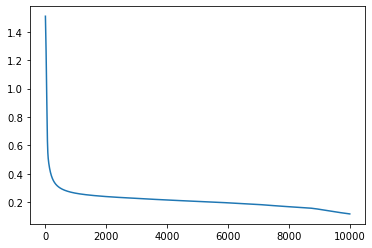

In [11]:
mlp_moons = MLP(2, 8, 8, 2, 0.0001, "normal", h_act="lrelu", o_act="softmax")
mlp_moons.fit(x_train_moons, y_train_moons_oh, 10000)
plt.plot(mlp_moons.losses)
print(f"Minimum loss: {min(mlp_moons.losses)}")
print (f"Accuracy of test inference: {accuracy(mlp_moons.infer(x_test_moons), y_test_moons_oh)}")

Minimum loss: 0.6313463583638991
Accuracy of test inference: 0.647


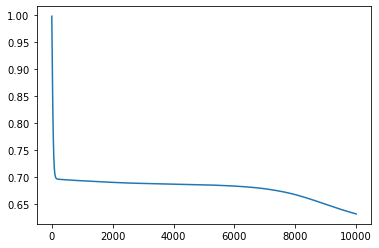

In [19]:
mlp_circles = MLP(2, 8, 8, 2, 0.0001, "normal", h_act="lrelu", o_act="softmax")
mlp_circles.fit(x_train_circles, y_train_circles_oh, 10000)
plt.plot(mlp_circles.losses)
print(f"Minimum loss: {min(mlp_circles.losses)}")
print (f"Accuracy of test inference: {accuracy(mlp_circles.infer(x_test_circles), y_test_circles_oh)}")

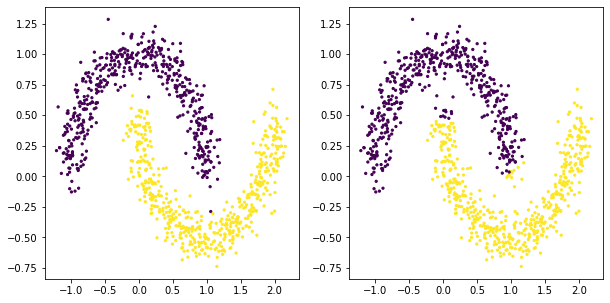

In [20]:
test_results = mlp_moons.infer(x_test_moons)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].scatter(x_test_moons[:, 0], x_test_moons[:, 1], c=y_test_moons, s=5)
axes[1].scatter(x_test_moons[:, 0], x_test_moons[:, 1], c=from_onehot(test_results, moons_dict), s=5)
plt.show()

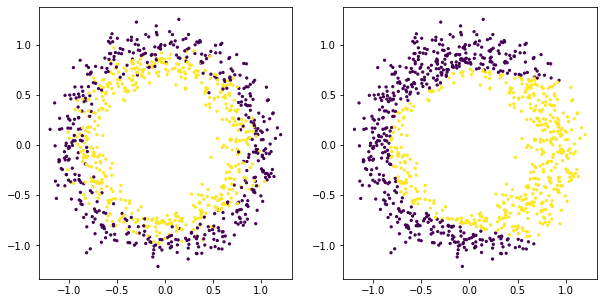

In [21]:
test_results = mlp_circles.infer(x_test_circles)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].scatter(x_test_circles[:, 0], x_test_circles[:, 1], c=y_test_circles, s=5)
axes[1].scatter(x_test_circles[:, 0], x_test_circles[:, 1], c=from_onehot(test_results, circles_dict), s=5)
plt.show()

In [22]:
### Test if MLP from scikit learn is better

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=42, hidden_layer_sizes=(8,), solver='sgd', max_iter=5000, activation='relu')
clf.fit(x_train_moons, y_train_moons)
clf.score(x_test_moons, y_test_moons)

0.876

In [23]:
def meshgrid_infer(x_test, y_test, model):
    '''
    Plot a mesh grid that represents area of model predictions vs points show true values
    
    Parameters:
    x_test: model inputs
    y_test: true labels
    
    Returns:
    plt.plot: Mesh grid with plotted (x_test, y_test)
    
    '''
    ## x is the training data matrix
    x1 = x2 = np.arange(np.min(x_test)-0.5, np.max(x_test)+0.5, 0.1)
    xx, yy = np.meshgrid(x1, x2)
    xx, yy = xx.reshape(len(x1)**2), yy.reshape(len(x1)**2)
    inp = np.transpose(np.vstack((xx, yy)))
    ## predict generated points on the grid from the trained mlp model
    out_mlp = model.infer(inp)
    pred_mlp = np.argmax(out_mlp, 1).reshape(len(x1), len(x1))
    
    ## plot the points
    plt.contourf(x1, x2, pred_mlp, cmap="cool")
    plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, s=5)
    plt.show()

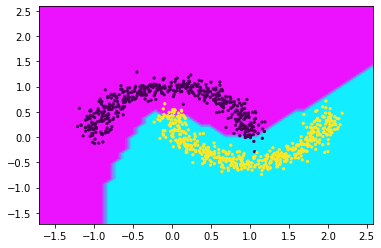

In [24]:
meshgrid_infer(x_test_moons, y_test_moons, mlp_moons)

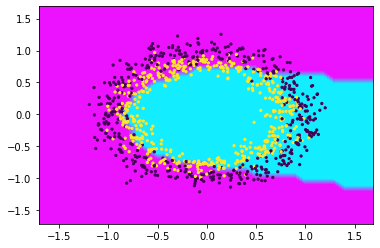

In [25]:
meshgrid_infer(x_test_circles, y_test_circles, mlp_circles)

In [ ]:
# class MLP_1h():
#     def __init__(self, input_nodes, hidden_nodes, output_nodes, lr, init):
#         self.input_nodes = input_nodes
#         self.hidden_nodes = hidden_nodes
#         self.output_nodes = output_nodes
#         self.init = init ## xavier, normal, rand
        
#         ### weights
#         if (self.init == "rand"): # also called xavier
#             self.w_ih = np.random.uniform(low=-1.0, high=1.0, size=(self.hidden_nodes, self.input_nodes))
#             self.w_ho = np.random.uniform(low=-1.0, high=1.0, size=(self.output_nodes, self.hidden_nodes))
            
#             self.b_ih = np.random.uniform(low=-1.0, high=1.0, size=(self.hidden_nodes, 1))
#             self.b_ho = np.random.uniform(low=-1.0, high=1.0, size=(self.hidden_nodes, 1))
            
#         elif (self.init == "normal"):
#             # init point=0.0, std = pow(out_nodes, -0.5), size=(self.hidden_nodes, self.input_nodes)
#             self.w_ih = np.random.normal(0.0, pow(self.hidden_nodes, -0.5), (self.hidden_nodes, self.input_nodes)) 
#             self.w_ho = np.random.normal(0.0, pow(self.output_nodes, -0.5), (self.output_nodes, self.hidden_nodes))
            
#             self.b_ih = np.random.normal(0.0, pow(self.output_nodes, -0.5), (self.hidden_nodes, 1))
#             self.b_ho = np.random.normal(0.0, pow(self.output_nodes, -0.5), (self.output_nodes, 1))
       
#         self.act = lambda x: relu(x)
#         self.act_out = lambda x: sigmoid(x)
        
#         self.lr = lr
        
#         self.losses = []
        
#     def forward_pass(self):
#         pass
    
#     def backward_pass(self):
#         pass
    
#     def train(self, inputs_list, targets_list):
#         inputs = np.array(inputs_list, ndmin=2).T
#         targets = np.array(targets_list, ndmin=2).T
        
#         hidden_inputs = self.w_ih @ inputs + self.b_ih
#         hidden_outputs = self.act(hidden_inputs)
        
#         output_inputs = self.w_ho @ hidden_outputs + self.b_ho
#         output_outputs = self.act_out(output_inputs)
        
#         output_errors = cross_entropy_loss(targets, output_outputs)
#         self.losses.append(output_errors)
        
#         e_out = cross_entropy_loss(targets, output_outputs, d=True)
                
#         delta2 = e_out * (output_outputs * (1 - output_outputs))
#         dw_ho = delta2 @ hidden_outputs.T
        
#         # update
#         self.w_ho += dw_ho * self.lr
#         self.b_ho += np.sum(delta2, axis=1, keepdims=True) * self.lr
        
#         delta1 = (self.w_ho.T @ delta2) * hidden_outputs * (1 - hidden_outputs)   
#         dw_ih = delta1 @ inputs.T 
         
#         # update
#         self.w_ih += dw_ih * self.lr
#         self.b_ih += np.sum(delta1, axis=1, keepdims=True) * self.lr
    
#     def infer(self, inputs_list):
#         inputs = np.array(inputs_list, ndmin=2).T
        
#         hidden_inputs = self.w_ih @ inputs + self.b_ih
#         hidden_outputs = self.act(hidden_inputs)
        
#         output_inputs = self.w_ho @ hidden_outputs + self.b_ho
#         output_outputs = self.act_out(output_inputs)
        
#         return output_outputs
    
#     def fit(self, inputs_list, targets_list, epochs=10000):
#         for epoch in range(epochs):
#             self.train(inputs_list, targets_list)
#             # for i,item in enumerate(inputs_list):
#                 # print (f"Epoch {epoch} : input - {inputs_list[i]}, target - {targets_list[i]}")
                
# mlp = MLP(2, 3, 2, 0.001, "normal")